## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [0]:
from PIL import Image

In [0]:
import keras

Using TensorFlow backend.


In [0]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling2D
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop

## Helper Functions

### Helper-function for printing confusion matrix

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for loading images

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values recorded during training with the Keras API.

In [0]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    
    # Plot title and legend.
    plt.title('Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

### Helper function to print status of layers (trainable/non-trainable)

In [0]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

## Preprocessing

In [0]:
train_dir = "train"

In [0]:
test_dir = "test"

In [0]:
batch_size = 10

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(299, 299),
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 10000 images belonging to 5 classes.


[ 0.  1.  0.  0.  0.]


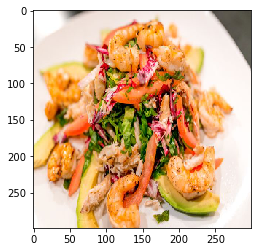

In [0]:
plt.imshow(train_generator[0][0][0])
print(train_generator[0][1][0])

[ 0.  0.  1.  0.  0.]


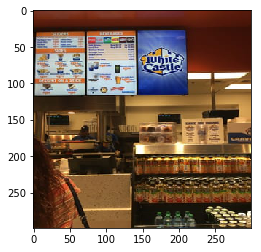

In [0]:
plt.imshow(train_generator[0][0][3])
print(train_generator[0][1][3])

In [0]:
test_generator = datagen.flow_from_directory(directory=test_dir,
                                                    target_size=(299, 299),
                                                    batch_size=batch_size)                                                   

Found 1000 images belonging to 5 classes.


In [0]:
class_names = list(test_generator.class_indices.keys())
class_names

['drink', 'food', 'inside', 'menu', 'outside']

## Pre-Trained Model: Inception_V3


In [0]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [0]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(299, 299)

In [0]:
# check the layers by name
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Write final layers

In [0]:
transfer_layer = model.get_layer('mixed10')

In [0]:
transfer_layer.output

<tf.Tensor 'mixed10/concat:0' shape=(?, 8, 8, 2048) dtype=float32>

In [0]:
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [0]:
import tensorflow as tf
tf.__version__

'1.5.1'

In [0]:
# Start a new Keras Sequential model.
new_model = Sequential()

In [0]:
new_model.add(conv_model)

In [0]:
shape = transfer_layer.output.shape[1:3]
shape

TensorShape([Dimension(8), Dimension(8)])

In [0]:
new_model.add(AveragePooling2D(pool_size = (8,8)))

new_model.add(Flatten())

new_model.add(Dropout(0.6))

new_model.add(Dense(5, activation='softmax'))

# Transfer Learning

In [0]:
optimizer = Adam(lr=1e-4)

In [0]:
loss = 'categorical_crossentropy'

In [0]:
metrics = ['categorical_accuracy']

In [0]:
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [0]:
print_layer_trainable()

False:	input_1
False:	conv2d_1
False:	batch_normalization_1
False:	activation_1
False:	conv2d_2
False:	batch_normalization_2
False:	activation_2
False:	conv2d_3
False:	batch_normalization_3
False:	activation_3
False:	max_pooling2d_1
False:	conv2d_4
False:	batch_normalization_4
False:	activation_4
False:	conv2d_5
False:	batch_normalization_5
False:	activation_5
False:	max_pooling2d_2
False:	conv2d_9
False:	batch_normalization_9
False:	activation_9
False:	conv2d_7
False:	conv2d_10
False:	batch_normalization_7
False:	batch_normalization_10
False:	activation_7
False:	activation_10
False:	average_pooling2d_1
False:	conv2d_6
False:	conv2d_8
False:	conv2d_11
False:	conv2d_12
False:	batch_normalization_6
False:	batch_normalization_8
False:	batch_normalization_11
False:	batch_normalization_12
False:	activation_6
False:	activation_8
False:	activation_11
False:	activation_12
False:	mixed0
False:	conv2d_16
False:	batch_normalization_16
False:	activation_16
False:	conv2d_14
False:	conv2d_17
False:	

Once we have changed whether the model's layers are trainable, we need to compile the model for the changes to take effect.

In [0]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [0]:
epochs = 100
steps_per_epoch = 10

In [0]:
history = new_model.fit_generator(generator=train_generator,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch)

Epoch 1/100
10/10 [==============================] - 110s 11s/step - loss: 1.9081 - categorical_accuracy: 0.1700
Epoch 2/100
10/10 [==============================] - 94s 9s/step - loss: 1.6030 - categorical_accuracy: 0.3100
Epoch 3/100
10/10 [==============================] - 97s 10s/step - loss: 1.5141 - categorical_accuracy: 0.4400
Epoch 4/100
10/10 [==============================] - 93s 9s/step - loss: 1.4807 - categorical_accuracy: 0.4500
Epoch 5/100
10/10 [==============================] - 93s 9s/step - loss: 1.4285 - categorical_accuracy: 0.4900
Epoch 6/100
10/10 [==============================] - 103s 10s/step - loss: 1.3583 - categorical_accuracy: 0.4700
Epoch 7/100
10/10 [==============================] - 113s 11s/step - loss: 1.2668 - categorical_accuracy: 0.5500
Epoch 8/100
10/10 [==============================] - 107s 11s/step - loss: 1.5583 - categorical_accuracy: 0.4000
Epoch 9/100
10/10 [==============================] - 118s 12s/step - loss: 1.2342 - categorical_accurac

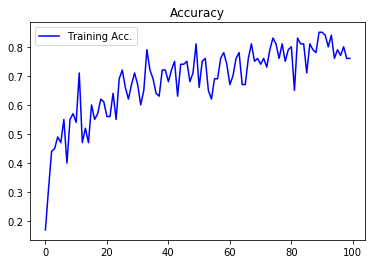

In [0]:
plot_training_history(history)

In [0]:
for i in (new_model.metrics_names,new_model.evaluate_generator(test_generator)):
  print(i)

['loss', 'categorical_accuracy']
[1.0935718622803687, 0.59700000561773781]


# Fine Tuning

In [0]:
conv_model.trainable = True

In [0]:
for layer in conv_model.layers[249:]:
    layer.trainable = True

In [0]:
print_layer_trainable()

False:	input_1
False:	conv2d_1
False:	batch_normalization_1
False:	activation_1
False:	conv2d_2
False:	batch_normalization_2
False:	activation_2
False:	conv2d_3
False:	batch_normalization_3
False:	activation_3
False:	max_pooling2d_1
False:	conv2d_4
False:	batch_normalization_4
False:	activation_4
False:	conv2d_5
False:	batch_normalization_5
False:	activation_5
False:	max_pooling2d_2
False:	conv2d_9
False:	batch_normalization_9
False:	activation_9
False:	conv2d_7
False:	conv2d_10
False:	batch_normalization_7
False:	batch_normalization_10
False:	activation_7
False:	activation_10
False:	average_pooling2d_1
False:	conv2d_6
False:	conv2d_8
False:	conv2d_11
False:	conv2d_12
False:	batch_normalization_6
False:	batch_normalization_8
False:	batch_normalization_11
False:	batch_normalization_12
False:	activation_6
False:	activation_8
False:	activation_11
False:	activation_12
False:	mixed0
False:	conv2d_16
False:	batch_normalization_16
False:	activation_16
False:	conv2d_14
False:	conv2d_17
False:	

**Lower learning rate**

In [0]:
optimizer_fine = Adam(lr=1e-5)

In [0]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [0]:
history = new_model.fit_generator(generator=train_generator,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch)

Epoch 1/100
10/10 [==============================] - 119s 12s/step - loss: 0.4567 - categorical_accuracy: 0.8600
Epoch 2/100
10/10 [==============================] - 115s 12s/step - loss: 0.5710 - categorical_accuracy: 0.7900
Epoch 3/100
10/10 [==============================] - 122s 12s/step - loss: 0.4406 - categorical_accuracy: 0.8700
Epoch 4/100
10/10 [==============================] - 118s 12s/step - loss: 0.5340 - categorical_accuracy: 0.8300
Epoch 5/100
10/10 [==============================] - 122s 12s/step - loss: 0.4836 - categorical_accuracy: 0.8800
Epoch 6/100
10/10 [==============================] - 119s 12s/step - loss: 0.4222 - categorical_accuracy: 0.8700
Epoch 7/100
10/10 [==============================] - 130s 13s/step - loss: 0.5996 - categorical_accuracy: 0.8300
Epoch 8/100
10/10 [==============================] - 134s 13s/step - loss: 0.3492 - categorical_accuracy: 0.9000
Epoch 9/100
10/10 [==============================] - 138s 14s/step - loss: 0.4338 - categorical_

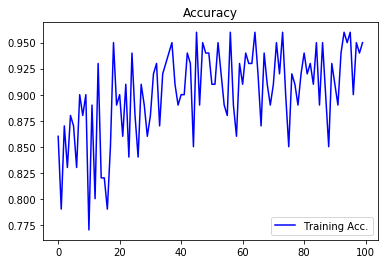

In [0]:
plot_training_history(history)

In [0]:
for i in (new_model.metrics_names,new_model.evaluate_generator(test_generator)):
  print(i)

['loss', 'categorical_accuracy']
[0.21794118258170783, 0.92799999237060549]


**Save the model**

In [0]:
new_model.save_weights('yelp_keras_weights.h5')

In [0]:
model.load_weights('yelp_keras_weights.h5', by_name=True)